<a href="https://colab.research.google.com/github/JALVITO/CE888/blob/master/Project/Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the data

In [38]:
import os
import random

from tabulate import tabulate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2

from sklearn.cluster import KMeans

# Keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Models and Pre-Processing
from tensorflow.keras.applications import VGG16, Xception, ResNet101, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [5]:
# Make sure GPU is enabled
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
# Config variables
DIM = 254
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
INIT_EPOCHS = 10
TUNE_EPOCHS = 10
TOTAL_EPOCHS = INIT_EPOCHS + TUNE_EPOCHS

In [7]:
%cd /content/drive/MyDrive/8voSemestre/CE888/Project/Data

# Extract file names from test dir
test_fire = ['Test/Fire/' + p for p in os.listdir('Test/Fire')]
test_no_fire = ['Test/No_Fire/' + p for p in os.listdir('Test/No_Fire')]

# Extract file names from training dir
train_fire = ['Training/Fire/' + p for p in os.listdir('Training/Fire')]
train_no_fire = ['Training/No_Fire/' + p for p in os.listdir('Training/No_Fire')]

test = test_fire + test_no_fire
train = train_fire + train_no_fire
fire = train_fire + test_fire
no_fire = train_no_fire + test_no_fire

/content/drive/MyDrive/8voSemestre/CE888/Project/Data


# Calculate data imbalance

In [8]:
# Determine sample size for test and training
def format_tabulate_row(fire, no_fire):
  n_fire = len(fire)
  n_no_fire = len(no_fire)
  n_total = n_fire + n_no_fire

  return [f'{n} ({n/n_total:.2%})' for n in [n_fire, n_no_fire, n_total]]

table = [['Test', *format_tabulate_row(test_fire, test_no_fire)],
         ['Train', *format_tabulate_row(train_fire, train_no_fire)]]

print('Data summary:')
print(tabulate(table, headers=['Fire','No Fire','Total'], tablefmt='grid'))

Data summary:
+-------+----------------+----------------+-----------------+
|       | Fire           | No Fire        | Total           |
+=======+================+================+=================+
| Test  | 5137 (59.61%)  | 3480 (40.39%)  | 8617 (100.00%)  |
+-------+----------------+----------------+-----------------+
| Train | 25018 (63.54%) | 14357 (36.46%) | 39375 (100.00%) |
+-------+----------------+----------------+-----------------+


# Data visualization

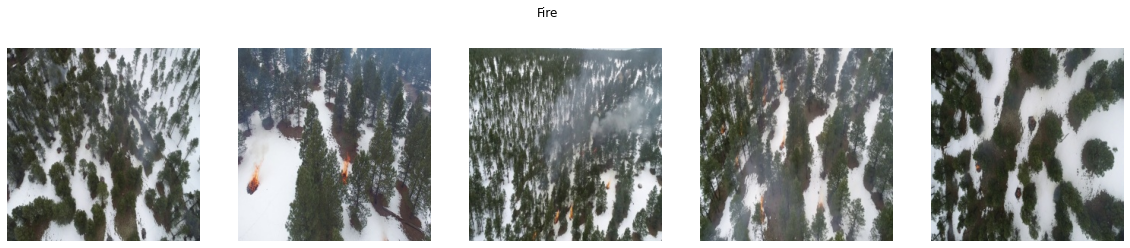

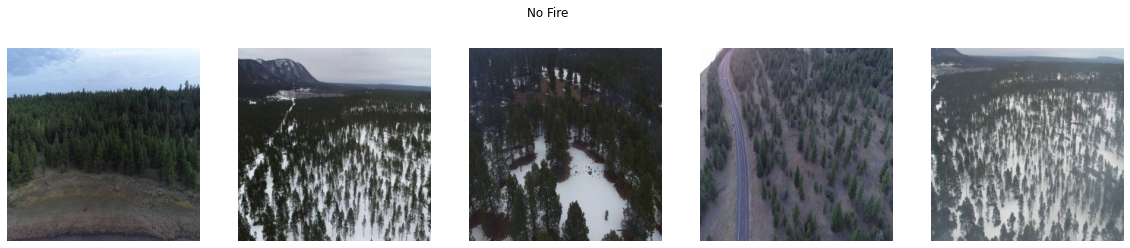

In [9]:
# Show some images
def show_sample_imgs(title, imgs, k):
  sample = random.sample(imgs, k)
  fig = plt.figure(figsize = (20,4))
  fig.suptitle(title)

  for i in range(k):
    img = cv2.imread(sample[i])
    plt.subplot(1, k, i+1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

k = 5
show_sample_imgs('Fire', fire, k)
show_sample_imgs('No Fire', no_fire, k)

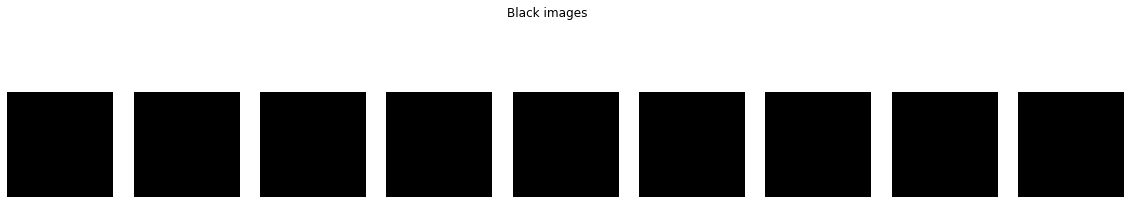

In [10]:
# Black images in test data set
black_imgs = [f'Test/No_Fire/resized_test_nofire_frame{i}.jpg' for i in range(3471, 3480)]
show_sample_imgs('Black images', black_imgs, 9)

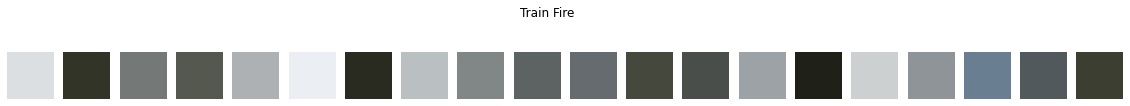

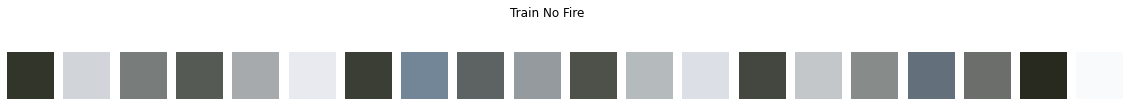

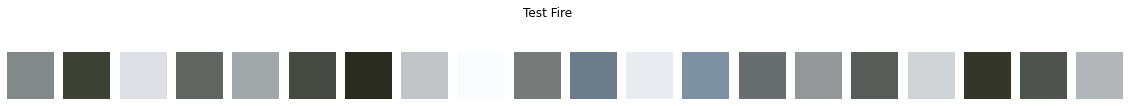

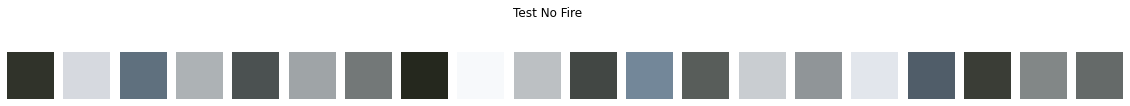

In [11]:
# Show most common colors
def show_most_common_colors(title, n_colors, imgs, k):
  fig = plt.figure(figsize = (20,2))
  fig.suptitle(title)
  sample = random.sample(fire, k)

  imgs = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in sample]
  concat = np.concatenate(imgs)
  colors = concat.reshape(-1,3)

  clt = KMeans(n_clusters=n_colors)
  clt.fit(colors)

  for i in range(n_colors):
    plt.subplot(1, n_colors, i+1)
    plt.axis('off')
    color = clt.cluster_centers_[i].reshape(1,1,3)
    plt.imshow(np.uint8(color))

n = 20
k = 5
show_most_common_colors('Train Fire', n, train_fire, k)
show_most_common_colors('Train No Fire', n, train_no_fire, k)
show_most_common_colors('Test Fire', n, test_fire, k)
show_most_common_colors('Test No Fire', n, test_no_fire, k)

# Exclusion of lake images

In [12]:
# Training set exluding lake images
train_no_fire_no_lake = [lbl for lbl in train_no_fire if 'lake' not in lbl]
print(f'No Fire train imgs without lake set: {len(train_no_fire_no_lake)}')

loss_ratio = len(train_no_fire_no_lake)/len(train_no_fire)

train_fire_no_lake = random.sample(train_fire, int(len(train_fire)*loss_ratio))
print(f'Artificial Fire train imgs without lake set: {len(train_fire_no_lake)}')

No Fire train imgs without lake set: 2510
Artificial Fire train imgs without lake set: 4373


# Data Pre-Processing

In [13]:
# Load data
print('Loading training data...')
train_data = image_dataset_from_directory('Training',
                                          batch_size=BATCH_SIZE,
                                          image_size=(DIM, DIM),
                                          validation_split=0.2,
                                          seed=42,
                                          subset="training")

print('\nLoading validation data...')
val_data = image_dataset_from_directory('Training',
                                          batch_size=BATCH_SIZE,
                                          image_size=(DIM, DIM),
                                          validation_split=0.2,
                                          seed=42,
                                          subset="validation")

print('\nLoading test data...')
test_data = image_dataset_from_directory('Test',
                                          batch_size=BATCH_SIZE,
                                          image_size=(DIM, DIM))

Loading training data...
Found 39375 files belonging to 2 classes.
Using 31500 files for training.

Loading validation data...
Found 39375 files belonging to 2 classes.
Using 7875 files for validation.

Loading test data...
Found 8617 files belonging to 2 classes.


In [14]:
# Create image augmentation layer
augment = Sequential([
     RandomFlip('horizontal'),
     RandomRotation(0.2),
     RandomZoom(0.1)
])

# First Model Experiments

In [15]:
models = [
  ResNet101(include_top=False, input_shape=(DIM,DIM,3)),
  VGG16(include_top=False, input_shape=(DIM,DIM,3)),
  Xception(include_top=False, input_shape=(DIM,DIM,3)),
  EfficientNetB0(include_top=False, input_shape=(DIM,DIM,3)),
]

preprocessors = [
  preprocess_vgg16,
  preprocess_xception,
  preprocess_resnet,
  preprocess_efficientnet,
]

In [16]:
# Build models
def build_model(base, preprocess):
  # Freeze model
  base.trainable = False

  inputs = Input(shape=(DIM, DIM, 3))
  x = augment(inputs)
  x = preprocess(x)
  x = base(x, training=False)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.2)(x)
  outputs = Dense(1)(x)

  return Model(inputs, outputs)

In [17]:
def train_model(model):
  model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model.fit(train_data, 
                   epochs=INIT_EPOCHS, 
                   validation_data=val_data)

In [18]:
def fine_tune_model(model, top_layers):
  # Unfreeze the top layers
  for layer in base.layers[-top_layers:]:
    layer.trainable = True

  model.compile(optimizer=Adam(lr=LEARNING_RATE/10),
                loss=BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model.fit(train_data, 
                   epochs=TOTAL_EPOCHS,
                   initial_epoch=INIT_EPOCHS,
                   validation_data=val_data)

In [20]:
# For the moment, only use first model
for base, preprocess in list(zip(models, preprocessors))[:1]:
  model = build_model(base, preprocess)
  print(model.summary())
  print('\nBegin training...')
  history = train_model(model)
  # print('\nBegin fine tuning...')
  # total_history = fine_tune_model(model)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 254, 254, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 254, 254, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 254, 254, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 254, 254, 3)       0         
_________________________________________________________________
resnet101 (Functional)       (None, 8, 8, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

In [21]:
# Save the model for future use
%mkdir -p saved_models
model.save('saved_models/model1') 

INFO:tensorflow:Assets written to: saved_models/model1/assets


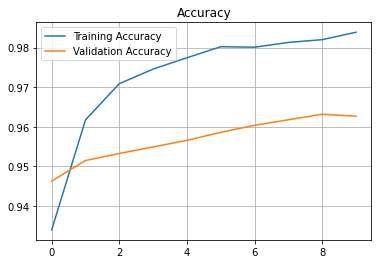

In [40]:
# Graph training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [39]:
# Print test accuracy
loss, accuracy = model.evaluate(test_data)
print('Test accuracy :', accuracy)

270/270 [==============================] - 2856s 11s/step - loss: 1.5049 - accuracy: 0.6284
Test accuracy : 0.6284089684486389
